In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

In [3]:
from torchvision.datasets import FashionMNIST

In [4]:
train_dataset = FashionMNIST(root='data/', download=True, train=True, transform=transforms.ToTensor())
test_dataset = FashionMNIST(root='data/', download=True, train=False, transform=transforms.ToTensor())

In [5]:
training_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [6]:
train_dataset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
image, label = next(iter(train_dataset))

'Ankle boot'

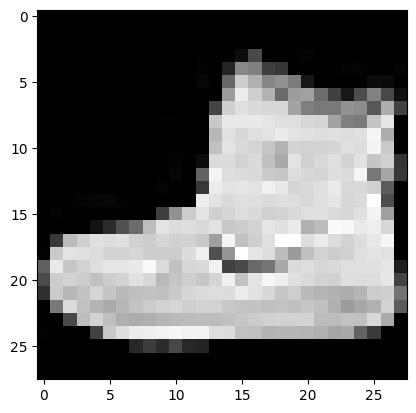

In [8]:
plt.imshow(image.squeeze(), cmap='gray')
train_dataset.classes[label]

# Convolution

https://en.wikipedia.org/wiki/Kernel_(image_processing)

![image.png](2D_Convolution_Animation.gif)

# AlexNet

https://en.wikipedia.org/wiki/AlexNet

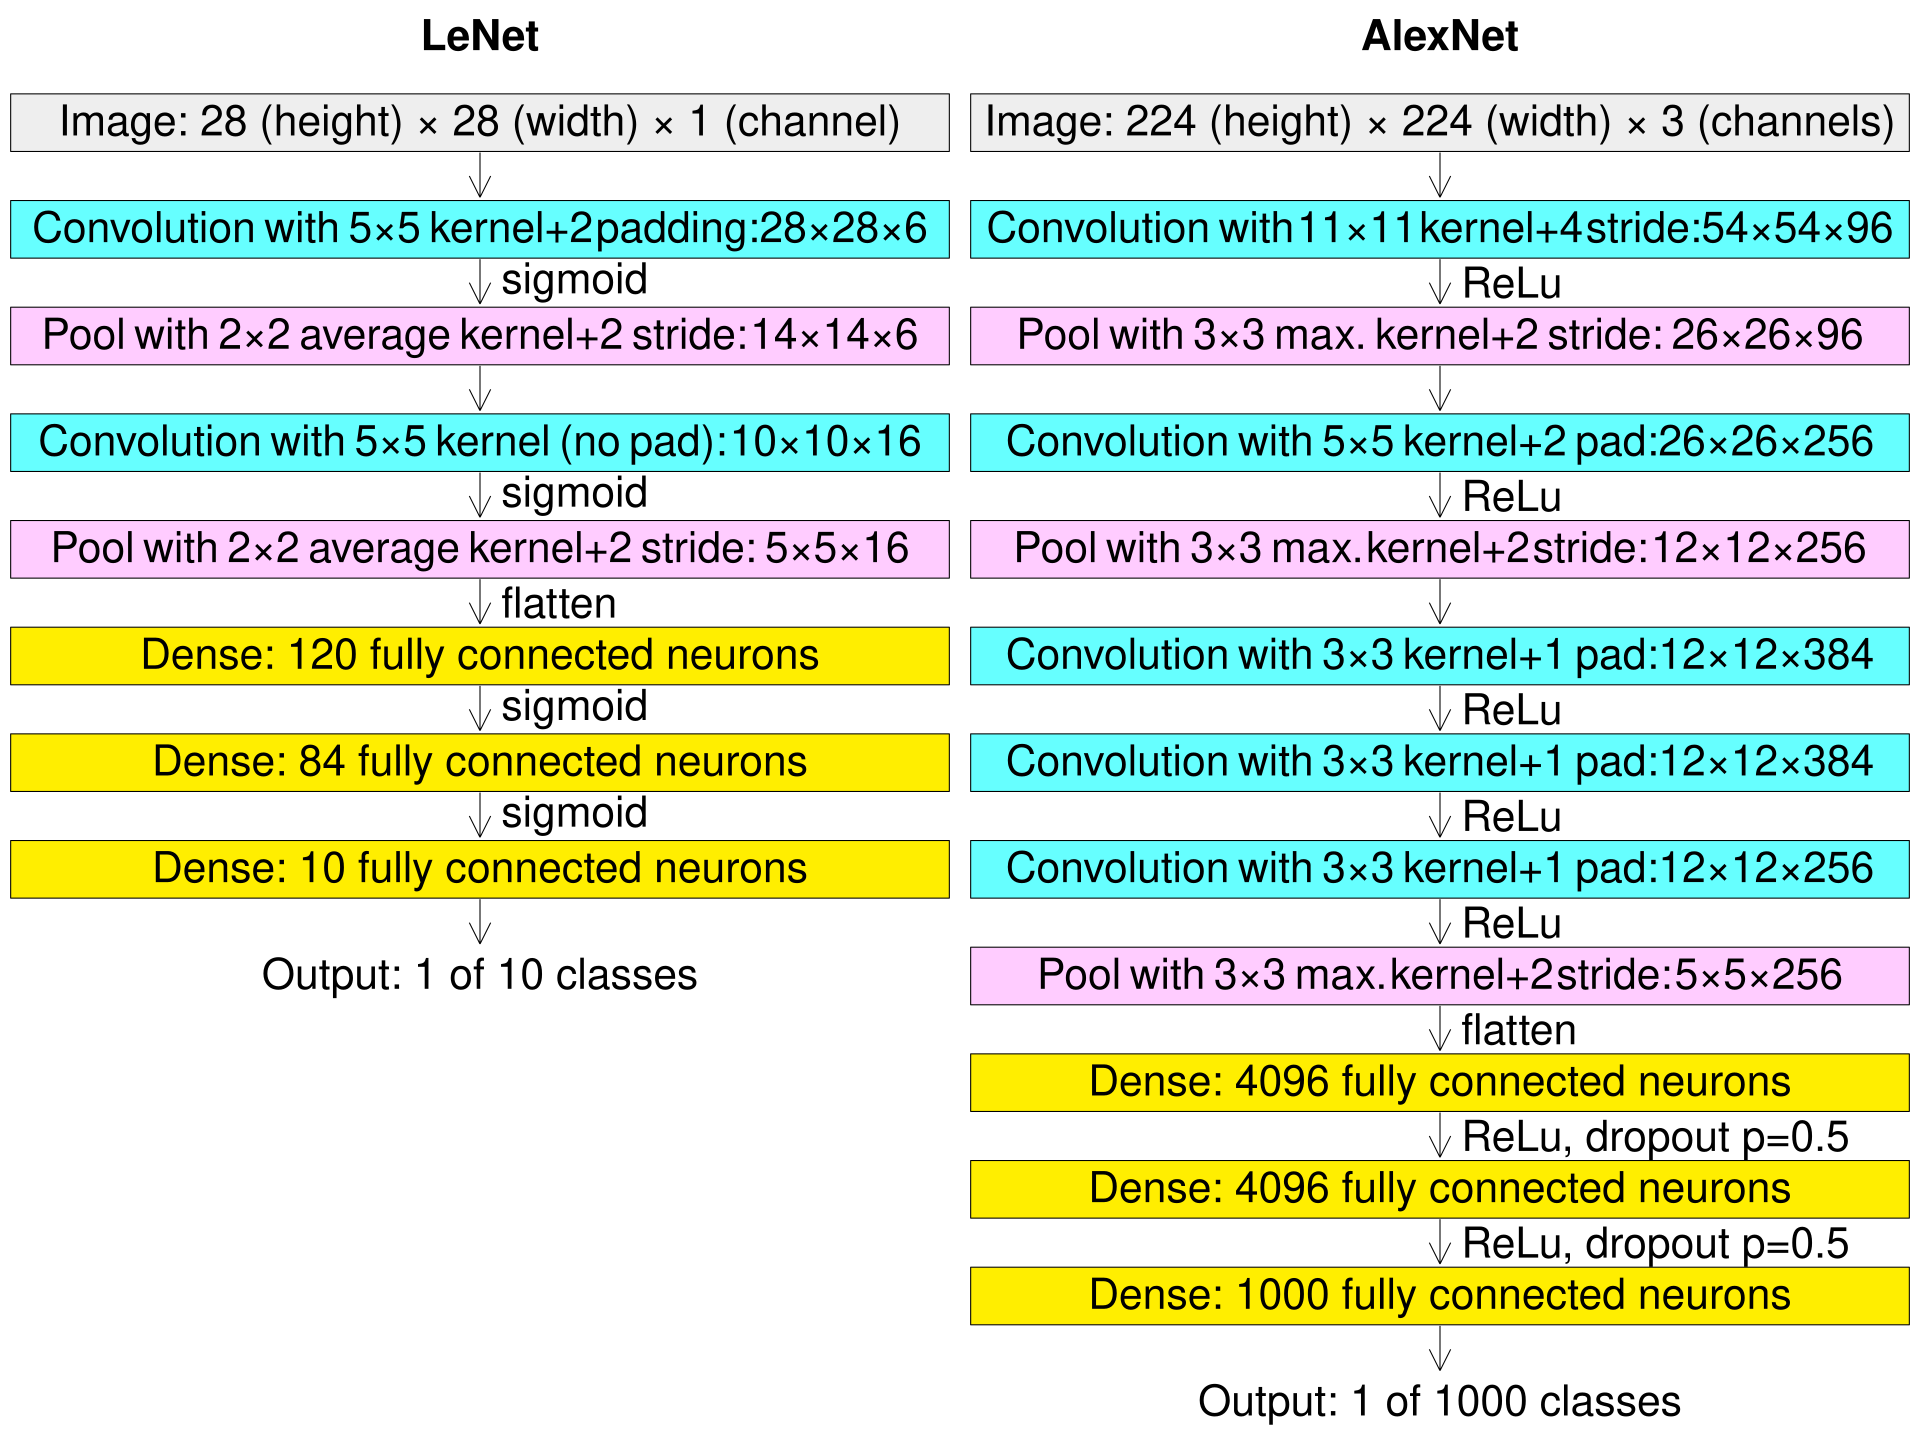

In [9]:
class FashionCNN(nn.Module):

    def __init__(self):
        super(FashionCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.mps is not None:
    device = torch.device("mps")

print(f"Using device {device}")

Using device mps


In [11]:
model = FashionCNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [13]:
def predict(model, test_dataset):
    with torch.no_grad():
        for image, labels in test_dataset:
            print(image.shape)
            image = image.to(device)
            plt.imshow(image.squeeze().cpu(), cmap='gray')
            output = model(image.unsqueeze(0))
            predicted = torch.max(output, 1)[1]
            print(f"{predicted}, Predicted={train_dataset.classes[predicted]}, Actual={train_dataset.classes[labels]}")
            break

torch.Size([1, 28, 28])
tensor([8], device='mps:0'), Predicted=Bag, Actual=Ankle boot


/Users/mehrshadshams/anaconda3/envs/deeplearning/lib/python3.11/site-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


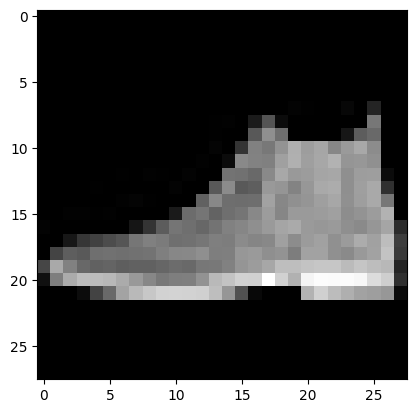

In [15]:
predict(model, test_dataset)

In [20]:
num_epochs = 5
count = 0
# Lists for visualization of loss and accuracy
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in training_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)

        # train = Variable(images.view(100, 1, 28, 28))
        # labels = Variable(labels)

        # Forward pass
        outputs = model(images)
        loss = error(outputs, labels)

        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()

        #Propagating the error backward
        loss.backward()

        # Optimizing the parameters
        optimizer.step()

        count += 1

    # Testing the model

        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0

            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)

                outputs = model(images)

                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()

                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.detach().cpu().numpy())
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Epoch: {}, Iteration: {}, Loss: {}, Accuracy: {}%".format(epoch, count, loss.data, accuracy))

/Users/mehrshadshams/anaconda3/envs/deeplearning/lib/python3.11/site-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 0, Iteration: 500, Loss: 0.6395269632339478, Accuracy: 86.22000122070312%
Epoch: 1, Iteration: 1000, Loss: 0.24364709854125977, Accuracy: 87.88999938964844%
Epoch: 1, Iteration: 1500, Loss: 0.40225455164909363, Accuracy: 85.58999633789062%
Epoch: 2, Iteration: 2000, Loss: 0.1069130226969719, Accuracy: 89.87000274658203%
Epoch: 2, Iteration: 2500, Loss: 0.2829712927341461, Accuracy: 89.94999694824219%
Epoch: 3, Iteration: 3000, Loss: 0.4537047743797302, Accuracy: 90.36000061035156%
Epoch: 3, Iteration: 3500, Loss: 0.3319953382015228, Accuracy: 90.2300033569336%
Epoch: 4, Iteration: 4000, Loss: 0.18486285209655762, Accuracy: 90.54000091552734%
Epoch: 4, Iteration: 4500, Loss: 0.151947021484375, Accuracy: 89.5199966430664%


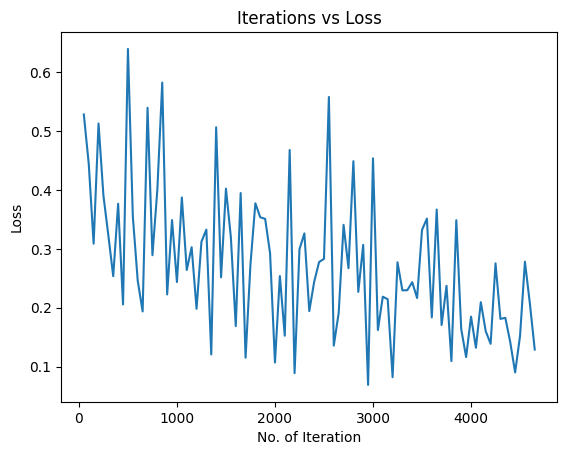

In [21]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

torch.Size([1, 28, 28])
tensor([9], device='mps:0'), Predicted=Ankle boot, Actual=Ankle boot


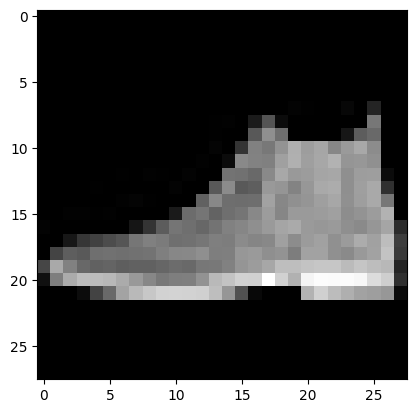

In [22]:
predict(model, test_dataset)